In [2]:
import pickle
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import xgboost as xgb
import matplotlib.pyplot as plt 
import seaborn as sns  
import time
from scipy import stats
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss  
from sklearn.pipeline import make_pipeline 
from sklearn.svm import LinearSVC, SVC 
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform, uniform
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, pearsonr

In [3]:
pd.pandas.set_option('display.max_columns', None)
data = pd.read_csv("../dataset/LPD_30k.csv", encoding = "unicode_escape")
data.head(10)

,Age,Gender,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Result
0,65.0,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1
5,46.0,Male,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,1
6,26.0,Female,0.9,0.2,154.0,NaN,12.0,7.0,3.5,1.00,1
7,29.0,Female,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.10,1
8,17.0,Male,0.9,0.3,202.0,22.0,19.0,7.4,4.1,1.20,2
9,55.0,Male,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.00,1


In [8]:
# Removing all the null values 
data = data.dropna()
data.shape

(27666, 11)

In [4]:
data["Result"] = data["Result"] - 1

In [5]:
data.shape

(30691, 11)

In [11]:
null_sum = data.isnull().sum()
null_percentage = (null_sum / len(data)) * 100
null_df = pd.concat([null_sum, null_percentage], axis=1)
null_df.columns = ['Null Count', 'Null Percentage']
null_df

,Null Count,Null Percentage
Age,0,0.0
T_Bil,0,0.0
D_Bil,0,0.0
Alkphos,0,0.0
Sgpt,0,0.0
Sgot,0,0.0
Total_Protiens,0,0.0
Alb,0,0.0
A/G,0,0.0
Result,0,0.0


In [6]:
# Label encoding 
le = LabelEncoder()
gender_encoded = le.fit_transform(data["Gender"])
data["Gender_encoded"] = gender_encoded
data = data.drop(["Gender"], axis = 1)
data.head(10)

,Age,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Result,Gender_encoded
0,65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,0,0
1,62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,0,1
2,62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,0,1
3,58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,0,1
4,72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,0,1
5,46.0,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,0,1
6,26.0,0.9,0.2,154.0,NaN,12.0,7.0,3.5,1.00,0,0
7,29.0,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.10,0,0
8,17.0,0.9,0.3,202.0,22.0,19.0,7.4,4.1,1.20,1,1
9,55.0,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.00,0,1


In [12]:
# Seperate the features and the labels
X = data.drop(["Result"], axis = 1)
y = data["Result"] 
print(X.shape, y.shape)

(16826, 10) (16826,)


In [9]:
duplicates = data[data.duplicated()]
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(16826, 11)

In [13]:
# Upsampling the data 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled.shape, y_resampled.shape 

((24104, 10), (24104,))

In [14]:
# Sanitary Check 
no_liver_disease, liver_disease = y_resampled.value_counts()
total_patients = no_liver_disease + liver_disease

print("Total patients: ", total_patients)

print("Number of patients with no liver disease", no_liver_disease)
print("Number of patients with liver disease: ", liver_disease)

print(f"Percentage negetive: {round(no_liver_disease/total_patients * 100, 3)} %")
print(f"Percentage positive: {round(liver_disease/total_patients* 100, 3)} %")

Total patients:  24104
Number of patients with no liver disease 12052
Number of patients with liver disease:  12052
Percentage negetive: 50.0 %
Percentage positive: 50.0 %


In [15]:
# Standardizing the data 
scaler = StandardScaler()
X_std = scaler.fit_transform(X_resampled)

X_std = pd.DataFrame(X_std, columns = X_resampled.columns)
X_std.head()

,Age,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Gender_encoded
0,1.303497,-0.372750,-0.435207,-0.379529,-0.329377,-0.300721,0.270394,0.124730,-0.231961,-1.300338
1,1.119693,1.547291,1.735875,1.969823,-0.015029,0.040183,0.917578,-0.001329,-0.741309,0.660582
2,1.119693,0.869629,1.173001,1.010810,-0.041225,-0.092853,0.455304,0.124730,-0.263795,0.660582
3,0.874620,-0.316279,-0.314592,-0.402472,-0.342475,-0.292406,0.270394,0.250789,0.086381,0.660582
4,1.732375,0.229615,0.328692,-0.342821,-0.257339,-0.130269,0.732669,-1.009799,-1.823672,0.660582


In [16]:
# Split of the standardized data 
X_train_val_std, X_test_std, y_train_val_std, y_test_std = train_test_split(X_std, y_resampled, test_size=0.15, random_state=42)

X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_train_val_std, y_train_val_std, test_size=0.15, random_state=42)

print('Train set size:', len(X_train_std))
print('Validation set size:', len(X_val_std))
print('Test set size:', len(X_test_std))

# Sanitary check
len(X_train_std) + len(X_val_std) + len(X_test_std)

Train set size: 17414
Validation set size: 3074
Test set size: 3616


24104

# Neural Networks

```Rest Neural Network Models are in Main.ipynb file```

__Four-layered Neural Network__

first layer - 100 (relu) second layer - 50 (relu) third layer - 25 (relu) fourth layer - 1 (sigmoid)

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape =  (10,), activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history6 = model.fit(X_train_std, y_train_std, epochs = 1000, callbacks = [early_stop])

Epoch 1/1000
545/545 [==============================] - 3s 3ms/step - loss: 0.5443 - accuracy: 0.7101
Epoch 2/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.4978 - accuracy: 0.7364
Epoch 3/1000
545/545 [==============================] - 3s 5ms/step - loss: 0.4577 - accuracy: 0.7693
Epoch 4/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.4151 - accuracy: 0.7940
Epoch 5/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.3774 - accuracy: 0.8218
Epoch 6/1000
545/545 [==============================] - 3s 5ms/step - loss: 0.3323 - accuracy: 0.8525
Epoch 7/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2989 - accuracy: 0.8678
Epoch 8/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2655 - accuracy: 0.8870
Epoch 9/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2444 - accuracy: 0.8959
Epoch 10/1000
545/545 [==============================] - 3s 5ms/step - loss: 0.216

In [24]:
nn6_train_time = 3.4*60 
start = time.time()
nn6_pred_prob = model.predict(X_test_std)
nn6_pred = np.where(nn6_pred_prob >= 0.5, 1, 0)
end = time.time()
nn6_pred_time = X_test_std.shape[0] / (end - start) 

train_percentage = model.evaluate(X_train_std, y_train_std)
val_percentage = model.evaluate(X_val_std, y_val_std)
test_percentage = model.evaluate(X_test_std, y_test_std)

conf_mat = confusion_matrix(y_test_std, nn6_pred)

113/113 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9947


: The time and speed analysis of the Wide-4-Layered NN algorithm : 
The training time of Wide-4-Layered NN is: 204.0 sec
The prediction speed of the Wide-4-Layered NN is: 6861 obs/sec
: The classifcation report of the Wide-4-Layered NN algorithm : 
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      1820
     Class 1       0.99      0.99      0.99      1796

    accuracy                           0.99      3616
   macro avg       0.99      0.99      0.99      3616
weighted avg       0.99      0.99      0.99      3616

Train Accuracy=99.59802627563477 %
Validation set accuracy = 99.44697618484497 %
Test Accuracy=99.47455525398254 %
: The confusion matrix of the Wide-4-Layered NN algorithm : 


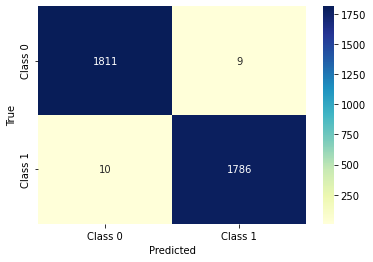

In [25]:
print(": The time and speed analysis of the Wide-4-Layered NN algorithm : ")
print(f'The training time of Wide-4-Layered NN is: {nn6_train_time} sec')
print(f'The prediction speed of the Wide-4-Layered NN is: {round(nn6_pred_time)} obs/sec')
print("=========================================================")
print(": The classifcation report of the Wide-4-Layered NN algorithm : ")

target_name = ['Class 0', 'Class 1']

print(classification_report(y_test_std, nn6_pred, target_names=target_name, zero_division=1.0))
print(f"Train Accuracy={train_percentage[1] * 100} %")
print(f"Validation set accuracy = {val_percentage[1] * 100} %")
print(f"Test Accuracy={test_percentage[1] * 100} %")
print("=========================================================")
print(": The confusion matrix of the Wide-4-Layered NN algorithm : ")
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt = 'd', xticklabels=target_name, yticklabels=target_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

__Six-layered Neural Networks__

first layer - 100(relu) second layer - 64 (relu) third layer - 32 (relu) fourth layer - 16 (relu) fifth layer - 4 (relu) sixth layer - 1 (sigmoid)

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape =  (10,), activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history7 = model.fit(X_train_std, y_train_std, epochs = 1000, callbacks = [early_stop])

Epoch 1/1000
545/545 [==============================] - 4s 4ms/step - loss: 0.5462 - accuracy: 0.7101
Epoch 2/1000
545/545 [==============================] - 3s 5ms/step - loss: 0.4889 - accuracy: 0.7405
Epoch 3/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.4391 - accuracy: 0.7770
Epoch 4/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.3868 - accuracy: 0.8074
Epoch 5/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.3407 - accuracy: 0.8368
Epoch 6/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2880 - accuracy: 0.8696
Epoch 7/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2591 - accuracy: 0.8928
Epoch 8/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.2083 - accuracy: 0.9152
Epoch 9/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.1870 - accuracy: 0.9263
Epoch 10/1000
545/545 [==============================] - 3s 6ms/step - loss: 0.156

In [21]:
nn7_train_time = 2.5*60 
start = time.time()
nn7_pred_prob = model.predict(X_test_std)
nn7_pred = np.where(nn7_pred_prob >= 0.5, 1, 0)
end = time.time()
nn7_pred_time = X_test_std.shape[0] / (end - start) 

train_percentage = model.evaluate(X_train_std, y_train_std)
val_percentage = model.evaluate(X_val_std, y_val_std)
test_percentage = model.evaluate(X_test_std, y_test_std)

conf_mat = confusion_matrix(y_test_std, nn7_pred)

113/113 [==============================] - 1s 6ms/step - loss: 0.0087 - accuracy: 0.9978


: The time and speed analysis of the Six-Layered NN algorithm : 
The training time of Six-Layered NN is: 150.0 sec
The prediction speed of the Six-Layered NN is: 7377 obs/sec
: The classifcation report of the Six-Layered NN algorithm : 
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1820
     Class 1       1.00      1.00      1.00      1796

    accuracy                           1.00      3616
   macro avg       1.00      1.00      1.00      3616
weighted avg       1.00      1.00      1.00      3616

Train Accuracy=99.83346462249756 %
Validation set accuracy = 99.51203465461731 %
Test Accuracy=99.7787594795227 %
: The confusion matrix of the Six-Layered NN algorithm : 


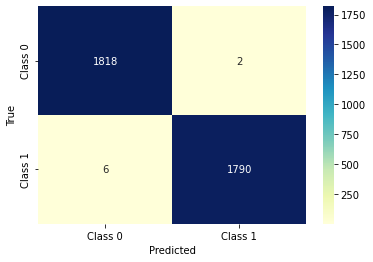

In [22]:
print(": The time and speed analysis of the Six-Layered NN algorithm : ")
print(f'The training time of Six-Layered NN is: {nn7_train_time} sec')
print(f'The prediction speed of the Six-Layered NN is: {round(nn7_pred_time)} obs/sec')
print("=========================================================")
print(": The classifcation report of the Six-Layered NN algorithm : ")

target_name = ['Class 0', 'Class 1']

print(classification_report(y_test_std, nn7_pred, target_names=target_name, zero_division=1.0))
print(f"Train Accuracy={train_percentage[1] * 100} %")
print(f"Validation set accuracy = {val_percentage[1] * 100} %")
print(f"Test Accuracy={test_percentage[1] * 100} %")
print("=========================================================")
print(": The confusion matrix of the Six-Layered NN algorithm : ")
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt = 'd', xticklabels=target_name, yticklabels=target_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()